In [1]:
import os
from datetime import datetime
import random
#import copy
from collections import defaultdict
import numpy as np
import csv
from os import makedirs,path
import pandas as pd
import matplotlib.pyplot as plt
#\x1b[31m\"red\"\x1b[0m
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

now = datetime.now()
#default of no run name
runname=''#now.strftime("%H_%M")

scriptdir=os.getcwd() #os.path.dirname(__file__) 
datadir= os.path.join(scriptdir, 'data\\')#static ..\data\

def openfile(filename):
    f = open(filename, "r+")
    output = defaultdict(list)
    # output['L']=()
    # output['W'].ap
    # output['c'].ap
    # output['lyap']
    # output['std'].
    # output['g'].ap
    for line in f:
        if line:
            strlist = line.split()
            output['date'].append(str(strlist[0][:]))
            output['time'].append(str(strlist[1][:]))
            output['eps'].append(float(strlist[2][1:-1]))
            output['Lz'].append(float(strlist[3][:-1]))
            output['L'].append(float(strlist[4][:-1]))
            output['W'].append(float(strlist[5][:-1]))
            output['tLow'].append(float(strlist[6][:-1]))
            output['c'].append(float(strlist[7][:-1]))
            output['E'].append(float(strlist[8][:-1]))
            output['dim'].append(float(strlist[9][:-1]))
            output['lyap'].append(float(strlist[10][1:]))
            output['std'].append(float(strlist[11]))
            output['g'].append(float(strlist[12][:-1]))
            output['reals'].append(float(strlist[13]))
            if len(strlist) >=15:
                output['runtime'].append(float(strlist[14][:-1]))
            else: 
                output['runtime'].append(float(0))
            output['fname'].append(os.path.basename(filename))
    return output

def stats(file,warnc,bigc):
    if file.endswith('.txt'):
        data=openfile(file)
    else:
        data= pd.read_csv(file) 
    
    Lz=np.array(data['Lz'])
    L=np.array(data['L'])
    uniL=np.unique(L)
    uniLz=np.unique(Lz)
    

    print(uniLz)
    for l in uniL:
        curdata=data[L[:]==l]
        runt=np.array(curdata['runtime'])
        cstr=""

        t=runt/60
        c=np.array(curdata['c'])
        uniC=np.unique(c)
        minC=np.min(c)
        maxC=np.max(c)
        avgR=np.average(t)

        outstr=f"{bcolors.OKBLUE}"+"L= %d"%(l)+f"{bcolors.ENDC}"+", Count=%d, Avg Realizations=%.0f," % (curdata.size,curdata.size/uniC.size)
        outstr+="# of C's=%d, C range=(%.3f,%.3f)" % (uniC.size, np.min(c),np.max(c))
        if avgR > 120:
            outstr+=" Avg Runtime= %.1fh," % (avgR/60)
        else:
            outstr+=" Avg Runtime= %.1fm," % (avgR)

        #outstr+=" Min= %.0fm, Max= %.0fm" % (np.min(t),np.max(t))
        outstr+=""
        
        print(outstr)
        
        #print(uniC)
        for ci in uniC:
            count=c[c[:]==ci].size


            
            #if ci < .271:
                #continue
            if count < warnc:
                cstr+= f"{bcolors.FAIL}"
            elif count > bigc:
                cstr+= f"{bcolors.WARNING}"

            cstr+= "%.3f=%d"%(ci,count)
             
            if count < warnc or count > bigc:
                cstr+=f"{bcolors.ENDC}"
            cstr+=", "
        print(cstr)
        print("----------------------------------")

def combine(fl,csvfile):
    df=pd.DataFrame()
    for f in fl:
        fdict=openfile(f)
        df=df.append(pd.DataFrame.from_dict(fdict))
        
    pd.DataFrame(df).to_csv(csvfile,mode='a+')

def printV(str,v=True):
    if v:
        print(str)

In [2]:
df=pd.DataFrame()
E=2
W=10
count=0
tstdir=datadir#+'\\E2W10-L10-24\\'
verbose=False

for root, dirs, files in os.walk(tstdir):
        for name in files:
            filepath=os.path.join(root, name)
            bad=False
            badnames=['all','combo','bad','offdiag']

            for b in badnames:
                if b in name or name.endswith('.csv'):
                    bad=True

            if bad is True:
                printV('ignoring bad file: ' + name,verbose)
                continue
            if path.isfile(filepath):
                try:
                    data=openfile(filepath)
                except:
                    printV("error "+str(name),verbose)
                    continue

                Lz=np.array(data['Lz'])
                uniLz=np.unique(Lz)
                uniE=np.unique(data['E'])
                uniW=np.unique(data['W'])
                c=np.array(data['c'])
                unic=np.unique(data['c'])
                

                

                if 100000 in uniLz and E in uniE and W in uniW:
                    printV(str(uniLz) + " " +str(name)+ ' success',verbose)

                    df=df.append(pd.DataFrame.from_dict(data))
                else:
                    printV(str(name)+ ' reject',verbose)
                    #print(unic) #       else:
                    #print(str(uniLz) + " " +str(filename)+ ' fail')
                # L=np.array(data['L'])
                # c=np.array(data['c'])
                # rt=np.array(data['runtime'])
                # uniL=np.unique(L)

uniE=np.unique(df['E'])
uniW=np.unique(df['W'])
uniLz=np.unique(df['Lz'])

#now save as csv
for e in uniE:
    for w in uniW:
        for lz in uniLz:
            newfname = f"E{int(e)}W{int(w)}Lz{int(lz/1000)}K"
            printV(newfname,verbose)

            df_write = df.loc[(df['E']==e) & (df['W']==w) & (df['Lz']==lz) & (df['eps']==1.0)]
            print(df_write['fname'].unique())
            pd.DataFrame(df_write).to_csv(tstdir+newfname+'.csv',mode='w')


['E2W10-L10-15-10x.txt' 'E2W10-L10-15-1x-c11.txt' 'E2W10-L10-15-1x.txt'
 'E2W10-L11-15-3x-c33.txt' 'E2W10-L13-15-5x.txt' 'E2W10-L16-19-3x-c44.txt'
 'E2W10-L16-20-1x-c11.txt' 'E2W10-L21-24-2x-c11.txt' 'E2W10-L21-24-3x.txt'
 'E2W10numba-multi.txt' 'nmb-test.txt' 'nmba-lowL.txt'
 'E2W10-L10-14-10x.txt' 'E2W10-L10-16-3x.txt' 'E2W10-L10-16-5x.txt'
 'E2W10-L10-20-5x.txt' 'E2W10-L15-19-3x-c11.txt' 'E2W10-L16-20-3x.txt'
 'E2W10-L18-19-3x.txt' 'E2W10-L20-23-3x-c11.txt' 'E2W10-L20-24-3x-c11.txt'
 'E2W10-L20-24-5x.txt' 'E2W10-L25-26-3x.txt' 'E2W10-L25-28-3x-c11.txt'
 'E2W10-L25-28-3x.txt' 'E2W10-L25-28-5x.txt' 'E2W10-L26-28-5x.txt'
 'E2W10-L29-30-10x.txt' 'E2W10-L10-13-3x-c11.txt'
 'E2W10-L12-14-6x-c22.txt' 'E2W10-L14-16-6x-c11.txt'
 'E2W10-L17-18-3x-c10.txt' 'E2W10-L17-19-3x-c11.txt'
 'E2W10-L20-24-3x-c11(1).txt']


In [3]:
file = datadir+"E2W10Lz100K.csv"
stats(file,9,14)

df=pd.read_csv(file)

L=np.array(df['L'])
uniL=np.unique(L)


for l in uniL:
    curdata=df[L[:]==l]
    outstr=''
    cd=np.array(curdata['c'])
    uniC=np.unique(cd)

    for c in uniC:
        outstr+= "(%.3f-%d)"%(c,cd[cd[:]==c].size)
    #print(outstr)

[100000.]
L= 6, Count=1870, Avg Realizations=170,# of C's=11, C range=(0.271,0.331) Avg Runtime= 2.8m,
0.271=10, 0.284=10, 0.291=10, 0.296=10, 0.298=10, 0.301=10, 0.304=10, 0.306=10, 0.311=10, 0.318=10, 0.331=10, 
----------------------------------
L= 7, Count=1870, Avg Realizations=170,# of C's=11, C range=(0.271,0.331) Avg Runtime= 2.9m,
0.271=10, 0.284=10, 0.291=10, 0.296=10, 0.298=10, 0.301=10, 0.304=10, 0.306=10, 0.311=10, 0.318=10, 0.331=10, 
----------------------------------
L= 8, Count=2057, Avg Realizations=187,# of C's=11, C range=(0.271,0.331) Avg Runtime= 8.7m,
0.271=11, 0.284=11, 0.291=11, 0.296=11, 0.298=11, 0.301=11, 0.304=11, 0.306=11, 0.311=11, 0.318=11, 0.331=11, 
----------------------------------
L= 9, Count=2057, Avg Realizations=187,# of C's=11, C range=(0.271,0.331) Avg Runtime= 10.3m,
0.271=11, 0.284=11, 0.291=11, 0.296=11, 0.298=11, 0.301=11, 0.304=11, 0.306=11, 0.311=11, 0.318=11, 0.331=11, 
----------------------------------
L= 10, Count=9537, Avg Realizatio

In [25]:
# use the first 2 lines of the file to detect separator
temp_lines = csv_file.readline() + '\n' + csv_file.readline()
dialect = csv.Sniffer().sniff(temp_lines, delimiters=';,')

# remember to go back to the start of the file for the next time it's read
csv_file.seek(0) 

df = pd.read_csv(csv_file, sep=dialect.delimiter)

C:\Users\adfgo\AppData\Local\Temp/ipykernel_18416/320079975.py:2: DeprecationWarning: 'U' mode is deprecated
  with open(file, 'rU') as csvfile:


AttributeError: '_io.TextIOWrapper' object has no attribute 'next'

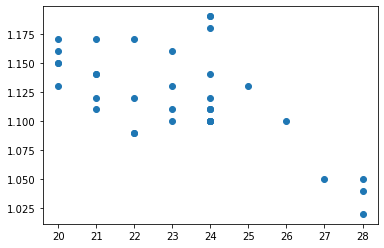

In [10]:
x=[24,24,24,25,26,27,28,28,28,20,20,20,20,20,21,21,21,21,21,22,22,22,22,23,23,23,23,24,24,24,24,24,24,24,24,24,24,24]
y=[1.1,1.1,1.11,1.13,1.1,1.05,1.02,1.04,1.05,1.16,1.17,1.13,1.15,1.15,1.12,1.17,1.11,1.14,1.14,1.09,1.17,1.09,1.12,1.11,1.16,1.1 ,1.13,1.11,1.1 ,1.1 ,1.1 ,1.19,1.19,1.18,1.1 ,1.14,1.11,1.12]
plt.scatter(x,y)



['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28']


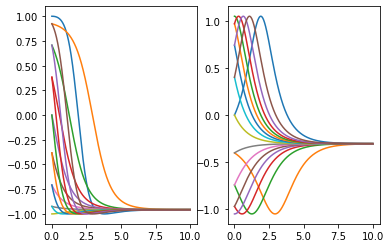

In [24]:
import numpy as np
import matplotlib.pyplot as plt

k0=np.arange(-np.pi, np.pi,np.pi/8)
klen=len(k0)
dt=10**-4
nstep=100000
t=np.arange(0,nstep*dt,dt)
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

for i in range(0,klen):
    nk=k0[i]
    E=np.zeros(nstep)
    v=np.zeros(nstep)
    for i in range(0,nstep):
        E[i]=-np.cos(nk)
        v[i]=1.05*np.sin(nk)
        dd=-.304-v[i]
        nk=dd*dt+nk
    ax1.plot(t,E)
    ax2.plot(t,v)
plt.show()